In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [2]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               865 non-null    object 
 1   SeasonNumber       865 non-null    int64  
 2   SeasonVersion      865 non-null    int64  
 3   Player             865 non-null    object 
 4   MatchId            865 non-null    object 
 5   Map                865 non-null    object 
 6   Category           865 non-null    object 
 7   Playlist           865 non-null    object 
 8   Input              865 non-null    object 
 9   Queue              865 non-null    object 
 10  PreCsr             865 non-null    int64  
 11  PostCsr            865 non-null    int64  
 12  Rank               865 non-null    int64  
 13  WasAtStart         865 non-null    int64  
 14  WasAtEnd           865 non-null    int64  
 15  WasInProgressJoin  865 non-null    int64  
 16  Mmr                2 non-n

In [3]:
# General Fixes+Additions
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
# Ratios
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
df['Damage/KA'] = df['DamageDone'] / (df['Kills'] + df['Assists'])
# Per 10 Min
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
# Excess
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
# Kill Type
df['BodyPct'] = df['KillsBody'] / df['Kills'] *100
df['MeleePct'] = df['KillsMelee'] / df['Kills'] * 100
df['HSPct'] = df['KillsHeadshot'] / df['Kills'] * 100
df['GrenadePct'] = df['KillsGrenade'] / df['Kills'] * 100
df['PowerPct'] = df['KillsPower'] / df['Kills'] * 100



df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'PreCsr', 'PostCsr', 'ShotsFired', 'AssistsEmp',
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides', 'WasAtStart', 'WasAtEnd', 'AssistsDriver',
              'Perfects', 'WasInProgressJoin', 'VehicleDestroys', 'VehicleHijacks', 'AssistsCallout',
              'LengthSeconds', 'Rank', 'SeasonNumber', 'SeasonVersion', 'Map'],axis=1)
df = df.drop(['KillsBody','KillsMelee', 'KillsGrenade', 'KillsHeadshot', 'KillsPower'], axis=1)
# df = df.drop(['Kills','Deaths', 'Assists', 'DamageDone', 'DamageTaken'], axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 140 to 864
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Outcome         603 non-null    int64  
 1   Accuracy        603 non-null    float64
 2   DamageDone      603 non-null    int64  
 3   DamageTaken     603 non-null    int64  
 4   KD              603 non-null    float64
 5   KDA             603 non-null    float64
 6   Kills           603 non-null    int64  
 7   Deaths          603 non-null    int64  
 8   Assists         603 non-null    int64  
 9   MaxSpree        603 non-null    int64  
 10  ExpectedKills   603 non-null    float64
 11  ExpectedDeaths  603 non-null    float64
 12  Score           603 non-null    int64  
 13  Medals          603 non-null    int64  
 14  LengthMinutes   603 non-null    float64
 15  DamageRatio     603 non-null    float64
 16  Damage/Kill     603 non-null    float64
 17  Damage/KA       603 non-null    f

In [4]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [5]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.434589
DmgT/10Min        0.360040
Deaths            0.312321
KD                0.311987
KDA               0.282454
Damage/KA         0.278577
ExcessDeaths      0.263059
DamageTaken       0.246722
ExpectedDeaths    0.203392
Assists/10Min     0.186578
Damage/Kill       0.178586
Kills/10Min       0.142904
LengthMinutes     0.133443
DamageRatio       0.125850
MaxSpree          0.112415
Accuracy          0.105344
DamageDone        0.088999
Assists           0.060238
BodyPct           0.054293
HSPct             0.050378
Dmg/10Min         0.040131
Score             0.035752
ExpectedKills     0.032542
GrenadePct        0.021483
Kills             0.019842
Medals            0.018892
MeleePct          0.015507
PowerPct          0.005506
ExcessKills       0.005401
Shots/10Min       0.002573
Name: Outcome, dtype: float64


In [6]:
# dfRR.hist(bins=15, figsize=(16, 12))
# plt.tight_layout()
# plt.show()

In [7]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,603.0,0.552239,0.497676,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,603.0,51.978060,5.230977,36.800000,48.610000,52.080000,55.025000,80.560000
DamageDone,603.0,5250.918740,1833.196352,667.000000,3893.500000,5027.000000,6450.500000,12673.000000
DamageTaken,603.0,4472.411277,1546.330028,35.000000,3452.000000,4288.000000,5498.500000,9962.000000
KD,603.0,1.270697,0.750152,0.270000,0.860000,1.130000,1.450000,10.000000
KDA,603.0,4.567413,5.587118,-9.660000,0.660000,4.660000,8.000000,31.000000
Kills,603.0,14.616915,6.296984,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,603.0,12.900498,5.181751,0.000000,9.000000,12.000000,16.000000,32.000000
Assists,603.0,8.558872,4.260742,1.000000,6.000000,8.000000,11.000000,28.000000
MaxSpree,603.0,3.953566,1.557694,1.000000,3.000000,4.000000,5.000000,10.000000


In [8]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [9]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (603, 30)
Y Shape: (603,)


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=27)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
# print(X_train.columns)
print(f'Y Train Mean: {round(y_train.mean(),3)}')
print(f'Y Test Mean: {round(y_test.mean(),3)}')

X Train Shape: (482, 30)
X Test Shape: (121, 30)
Y Train Mean: 0.558
Y Test Mean: 0.529


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Accuracy', 'ExpectedKills', 'ExpectedDeaths', 'KD', 
                                    'KDA', 'MaxSpree', 'Deaths', 'Assists', 'Kills', 'DamageDone', 
                                    'DamageTaken', 'Score', 'Medals', 'LengthMinutes', 
                                    'DamageRatio', 'Damage/Kill', 'Damage/KA', 
                                    'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
                                    'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths',
                                    'BodyPct', 'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'])])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# X_train_preprocessed.to_csv('X_train_preprocessed.csv')
# X_test_preprocessed.to_csv('X_test_preprocessed.csv')

print(f'X Train Processed Shape: {X_train_preprocessed.shape}')
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Processed Shape: {X_test_preprocessed.shape}')

X Train Processed Shape: (482, 30)
X Train Shape: (482, 30)
X Test Processed Shape: (121, 30)


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, log_loss, classification_report, confusion_matrix
MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  ll = log_loss(y_test,y_pred)
  clRep = classification_report(y_test, y_pred)
  confM = confusion_matrix(y_test, y_pred)

  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  print("Log Loss: {:.2f}".format(ll))
  print('---------------------------------------------------------')
  print(clRep)
  print('---------------------------------------------------------') 
  # print(confM)
  # print('---------------------------------------------------------') 
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

def coefs(mod):
  # Get the coefficients
  coefficients = mod.coef_[0]

  # Create a dictionary with feature names and their corresponding coefficients
  feature_coefficients = dict(zip(X_train.columns, coefficients))

  # Sort features by coefficients in descending order
  sorted_features = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=False)

  # Print or analyze the top 10 sorted feature coefficients
  print("Top 10 Sorted Feature Coefficients:")
  for feature, coefficient in sorted_features[:10]:
      print(f"{feature}: {coefficient:.2f}")


## Logistic Regression

In [13]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))
print(coefs(logreg))

Unregularized Logistic Regression Accuracy: 0.8347107438016529
Acc: 0.835
MAE: 0.17
MSE: 0.17
RMSE: 0.41
R^2 Score: 0.34
OOS R^2 Score: 0.34
Log Loss: 5.96
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        57
           1       0.85      0.83      0.84        64

    accuracy                           0.83       121
   macro avg       0.83      0.84      0.83       121
weighted avg       0.84      0.83      0.83       121

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
MeleePct: 0.03
PowerPct: -0.03
BodyPct: 0.04
Medals: -0.06
HSPct: -0.10
GrenadePct: 0.12
Shots/10Min: -0.12
Damage/Kill: -0.19
DamageTaken: -0.21
Kills: -0.29
None


## Ridge

In [14]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(ridge_cv))
print(ResultsOut(ridge_cv))
print(coefs(ridge_cv.best_estimator_))


LogisticRegression(C=10, solver='saga')
Ridge Accuracy: 0.8512396694214877
   C_param  Accuracy
0    0.001  0.647315
1    0.010  0.707453
2    0.100  0.757195
3    1.000  0.777857
4   10.000  0.779940
5  100.000  0.779940

Acc: 0.851
MAE: 0.15
MSE: 0.15
RMSE: 0.39
R^2 Score: 0.40
OOS R^2 Score: 0.40
Log Loss: 5.36
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        57
           1       0.87      0.84      0.86        64

    accuracy                           0.85       121
   macro avg       0.85      0.85      0.85       121
weighted avg       0.85      0.85      0.85       121

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
Medals: -0.00
MeleePct: 0.01
BodyPct: 0.04
PowerPct: -0.05
Shots/10Min: -0.06
HSPct: -0.09
GrenadePct: 0.13
Damage/Kill: -0.15
MaxSpree: 0.20
LengthMinutes: -0.26
None


## Lasso

In [15]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(lasso_cv))
print(ResultsOut(lasso_cv))
print(coefs(lasso_cv.best_estimator_))

LogisticRegression(C=100, penalty='l1', solver='saga')
Lasso Accuracy: 0.8429752066115702
   C_param  Accuracy
0    0.001  0.558097
1    0.010  0.558097
2    0.100  0.717805
3    1.000  0.771628
4   10.000  0.773711
5  100.000  0.777857

Acc: 0.843
MAE: 0.16
MSE: 0.16
RMSE: 0.40
R^2 Score: 0.37
OOS R^2 Score: 0.37
Log Loss: 5.66
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.84      0.83        57
           1       0.86      0.84      0.85        64

    accuracy                           0.84       121
   macro avg       0.84      0.84      0.84       121
weighted avg       0.84      0.84      0.84       121

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
Medals: -0.01
MeleePct: 0.01
BodyPct: 0.04
PowerPct: -0.05
Shots/10Min: -0.06
HSPct: -0.10
GrenadePct: 0.13
Damage/Kill: -0.14
MaxSpree: 0.21
LengthMinutes: -0.25
None


## ElasticNet

In [16]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(elastic_cv))
print(ResultsOut(elastic_cv))
print(coefs(elastic_cv.best_estimator_))



LogisticRegression(C=10, l1_ratio=0.25, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.8512396694214877
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.558097
1     0.001            0.50  0.558097
2     0.001            0.75  0.558097
3     0.010            0.25  0.688853
4     0.010            0.50  0.618192
5     0.010            0.75  0.558097
6     0.100            0.25  0.753071
7     0.100            0.50  0.736469
8     0.100            0.75  0.730284
9     1.000            0.25  0.779918
10    1.000            0.50  0.771628
11    1.000            0.75  0.769545
12   10.000            0.25  0.779940
13   10.000            0.50  0.779940
14   10.000            0.75  0.775795
15  100.000            0.25  0.777857
16  100.000            0.50  0.779940
17  100.000            0.75  0.779940

Acc: 0.851
MAE: 0.15
MSE: 0.15
RMSE: 0.39
R^2 Score: 0.40
OOS R^2 Score: 0.40
Log Loss: 5.36
---------------------------------------------------------
         

## K-Nearest Neighbours

In [17]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
print(paramResults(knn_cv))
print(ResultsOut(knn_cv))



KNeighborsClassifier(n_neighbors=46)
K-Nearest Neighbors Accuracy: 0.7024793388429752
    n_neighbors_param  Accuracy
0                   1  0.639089
1                   4  0.634944
2                   7  0.645168
3                  10  0.672186
4                  13  0.674356
5                  16  0.661963
6                  19  0.668106
7                  22  0.672251
8                  25  0.678522
9                  28  0.676439
10                 31  0.674313
11                 34  0.676375
12                 37  0.674334
13                 40  0.665979
14                 43  0.678436
15                 46  0.680563
16                 49  0.678436

Acc: 0.702
MAE: 0.30
MSE: 0.30
RMSE: 0.55
R^2 Score: -0.19
OOS R^2 Score: -0.19
Log Loss: 10.72
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        57
           1       0.72      0.72      0.72        64

    accuracy       

## Random Forest

In [18]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=69)
Random Forest Accuracy: 0.71900826446281
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.690936
1               10                 300  0.703393
2               10                 500  0.695103
3               15                 100  0.688810
4               15                 300  0.697143
5               15                 500  0.692955
6               20                 100  0.682582
7               20                 300  0.692998
8               20                 500  0.692955


''

In [19]:
ResultsOut(rf_cv)

Acc: 0.719
MAE: 0.28
MSE: 0.28
RMSE: 0.53
R^2 Score: -0.13
OOS R^2 Score: -0.12
Log Loss: 10.13
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        57
           1       0.73      0.75      0.74        64

    accuracy                           0.72       121
   macro avg       0.72      0.72      0.72       121
weighted avg       0.72      0.72      0.72       121

---------------------------------------------------------


''

<Axes: >

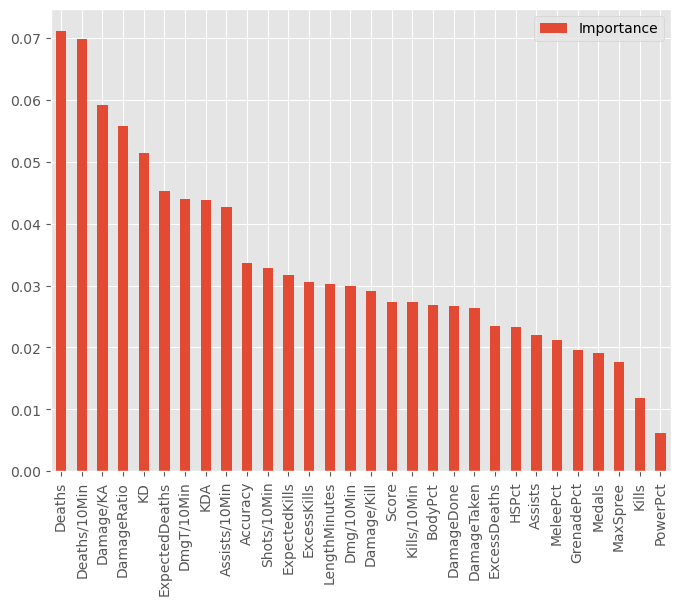

In [20]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [21]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,0.6,0.8,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(max_depth=2, random_state=69, subsample=0.5)
Gradient Boosed Trees Accuracy: 0.7024793388429752
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              0.6   
2                  0.01                2                 100              0.8   
3                  0.01                2                 100              1.0   
4                  0.01                2                 300              0.5   
..                  ...              ...                 ...              ...   
67                 0.10                6                 300              1.0   
68                 0.10                6                 500              0.5   
69                 0.10                6                 500              0.6   
70                 0.10                6                 500       

''

In [22]:
ResultsOut(GBRT)

Acc: 0.702
MAE: 0.30
MSE: 0.30
RMSE: 0.55
R^2 Score: -0.19
OOS R^2 Score: -0.19
Log Loss: 10.72
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.67      0.68        57
           1       0.71      0.73      0.72        64

    accuracy                           0.70       121
   macro avg       0.70      0.70      0.70       121
weighted avg       0.70      0.70      0.70       121

---------------------------------------------------------


''

<Axes: >

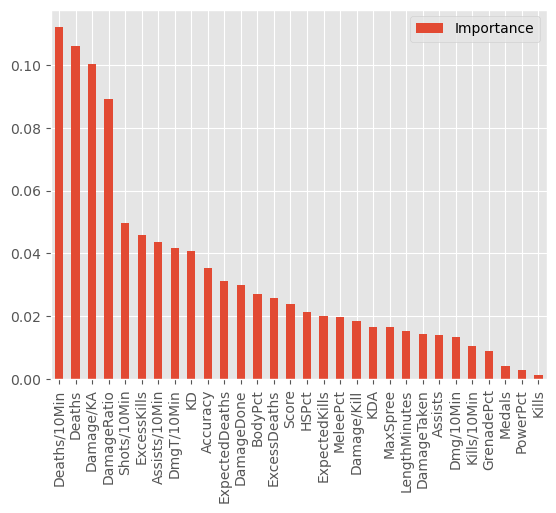

In [23]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [24]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [400,450,475,500],'learning_rate': [0.001,0.01,0.1,0.25],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=475, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.7272727272727273
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                 0.001                1                 400  0.632882
1                 0.001                1                 450  0.641216
2  

''

In [25]:
ResultsOut(XGB)

Acc: 0.727
MAE: 0.27
MSE: 0.27
RMSE: 0.52
R^2 Score: -0.09
OOS R^2 Score: -0.09
Log Loss: 9.83
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        57
           1       0.75      0.72      0.74        64

    accuracy                           0.73       121
   macro avg       0.73      0.73      0.73       121
weighted avg       0.73      0.73      0.73       121

---------------------------------------------------------


''

<Axes: >

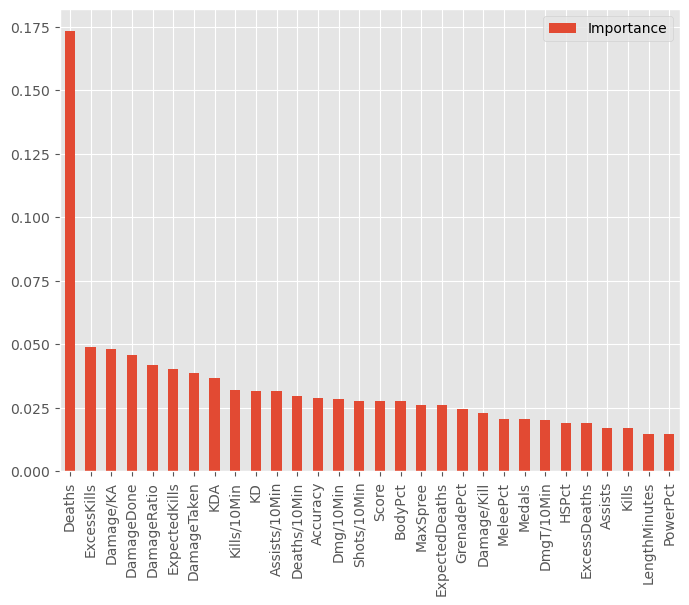

In [26]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:32], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Neural Net

In [27]:
from sklearn.neural_network import MLPClassifier

param_grid_nn = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
nn = GridSearchCV(estimator=MLPClassifier(random_state=61), cv=5, param_grid=param_grid_nn, n_jobs=-1)

nn.fit(X_train_preprocessed, y_train)
print(nn)
print(f'Neural Net Accuracy: {nn.score(X_test_preprocessed, y_test)}')

/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaron

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=61), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'solver': ['lbfgs', 'sgd', 'adam']})
Neural Net Accuracy: 0.8347107438016529


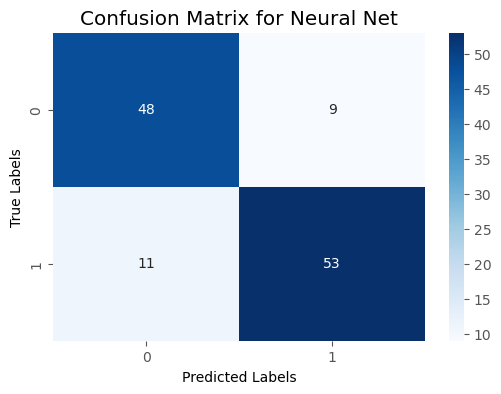

The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.


<Axes: >

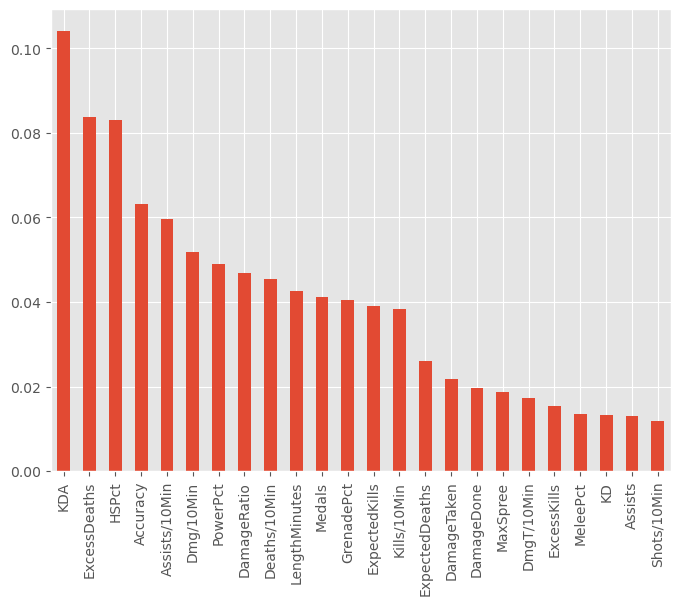

In [28]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix for the Neural Net
conf_matrix = confusion_matrix(y_test, nn.predict(X_test_preprocessed))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Net')
plt.show()

print("The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.")
feat_importances_nn = pd.DataFrame(nn.best_estimator_.coefs_[0].flatten()[:30], index=X_train.columns, columns=["Importance"])
feat_importances_nn = feat_importances_nn.abs().sum(axis=1)
feat_importances_nn = feat_importances_nn / feat_importances_nn.sum()
feat_importances_nn = feat_importances_nn.sort_values(ascending=False)[:24]
feat_importances_nn.plot(kind='bar', figsize=(8,6))

## Keras NN

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# Build the Keras model
model = Sequential([
    Dense(128, activation='relu', input_shape=(num_features,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_preprocessed, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=2)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test_preprocessed)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate accuracy (you can use other metrics depending on your needs)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

: 

,Model,ACC,MAE,MSE,RMSE,R2,OOS R2,Log Loss
0,Ridge,0.851,0.149,0.149,0.386,0.403,0.405,5.362
1,ElasticNet,0.851,0.149,0.149,0.386,0.403,0.405,5.362
2,Lasso,0.843,0.157,0.157,0.396,0.370,0.372,5.660
3,Logistic Regression,0.835,0.165,0.165,0.407,0.337,0.339,5.958
4,NeuralNet,0.835,0.165,0.165,0.407,0.337,0.339,5.958
5,XGBoost,0.727,0.273,0.273,0.522,-0.095,-0.091,9.830
6,Random Forest,0.719,0.281,0.281,0.530,-0.128,-0.124,10.128
7,K-Nearest Neighbors,0.702,0.298,0.298,0.545,-0.194,-0.190,10.724
8,Gradient Boosted Trees,0.702,0.298,0.298,0.545,-0.194,-0.190,10.724


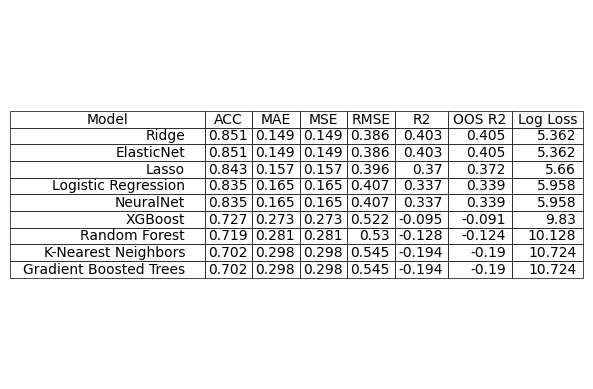

In [ ]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB,nn]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost', 'NeuralNet']
def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2', 'Log Loss'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        ll = round(log_loss(y_test,y_pred),3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2, ll]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig('ModelResults0210.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)


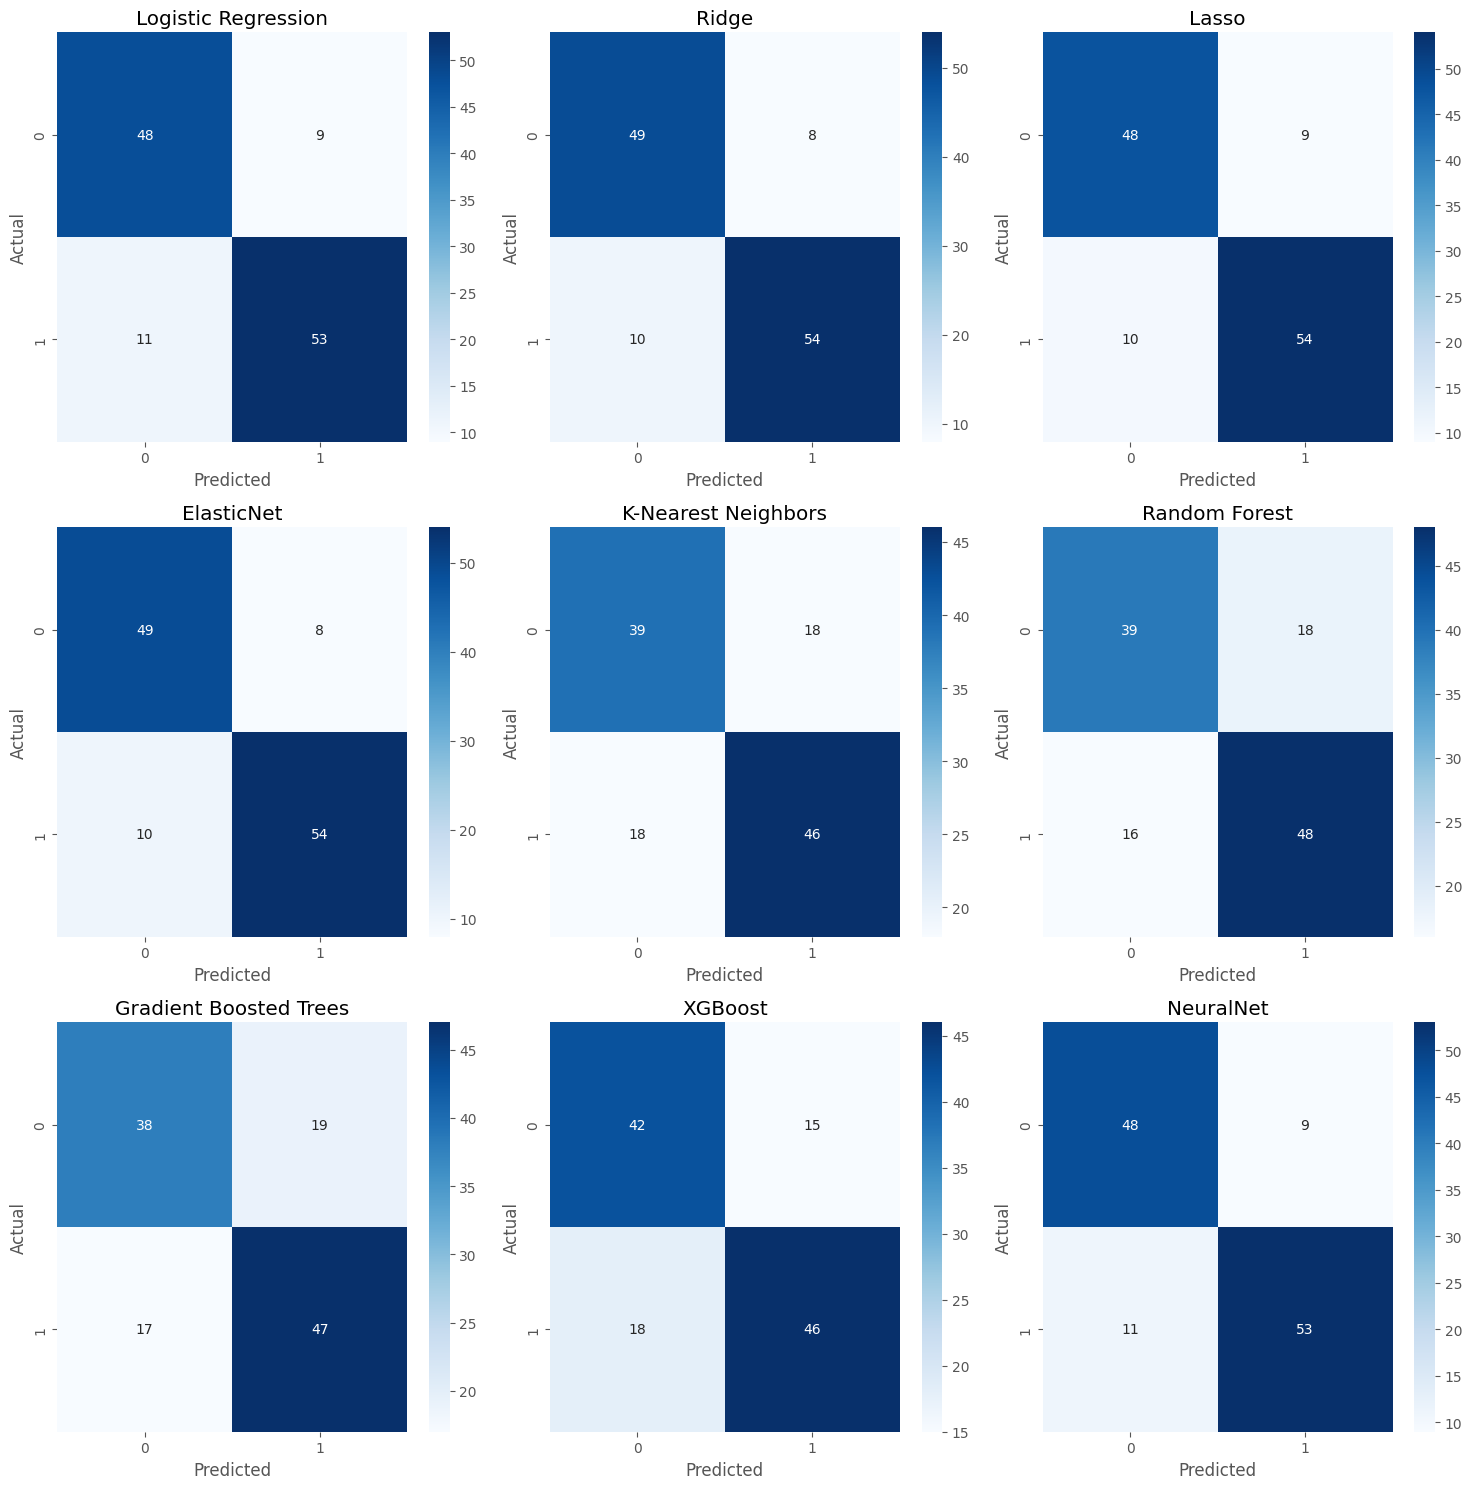

In [ ]:
# Assuming X_test_preprocessed and y_test are your test data
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, (model, model_name) in enumerate(zip(modelss, model_namess)):
    y_pred = model.predict(X_test_preprocessed)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(model_name)
    axs[i//3, i%3].set_xlabel('Predicted')
    axs[i//3, i%3].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('Plots/ConfusionMatrixMultigraph.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(f'Runtime: {round(time.perf_counter() - start,2)}s')

Runtime: 83.59s


In [ ]:
X_trainp_df = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
round(X_trainp_df.describe().transpose(),3).sort_values(by='max',ascending=False)

,count,mean,std,min,25%,50%,75%,max
DamageRatio,482.0,-0.0,1.001,-2.015,-0.725,-0.094,0.526,6.674
Shots/10Min,482.0,0.0,1.001,-3.503,-0.596,-0.021,0.545,6.212
KD,482.0,-0.0,1.001,-1.568,-0.625,-0.209,0.331,5.994
PowerPct,482.0,0.0,1.001,-0.377,-0.377,-0.377,-0.377,5.847
Damage/KA,482.0,0.0,1.001,-2.047,-0.658,-0.135,0.481,5.401
Accuracy,482.0,0.0,1.001,-2.855,-0.674,0.017,0.561,5.357
Score,482.0,-0.0,1.001,-2.124,-0.792,-0.106,0.627,5.172
KDA,482.0,0.0,1.001,-2.600,-0.713,0.018,0.567,4.835
Medals,482.0,-0.0,1.001,-1.766,-0.667,-0.117,0.432,4.553
Assists,482.0,0.0,1.001,-1.818,-0.621,-0.143,0.576,4.405
